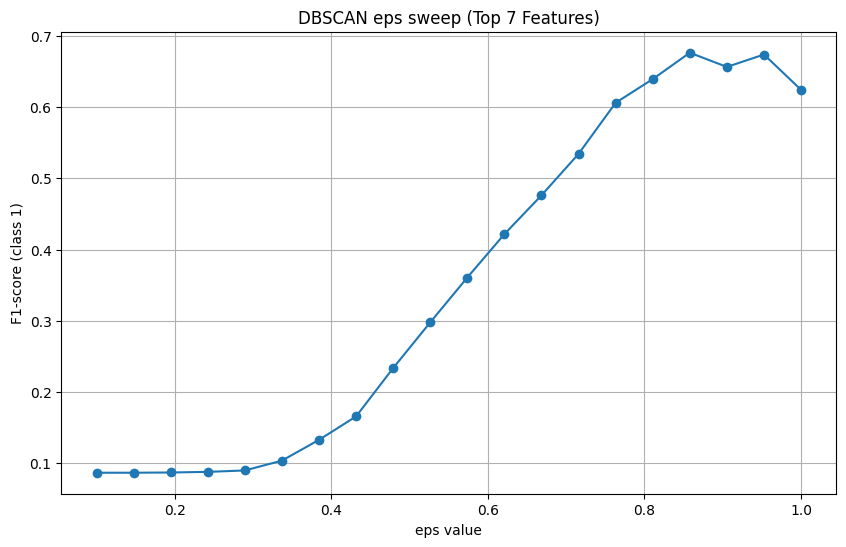


✅ Best eps = 0.86 with F1 = 0.6763
Confusion Matrix:
[[1427   66]
 [   1   70]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1493
           1       0.51      0.99      0.68        71

    accuracy                           0.96      1564
   macro avg       0.76      0.97      0.83      1564
weighted avg       0.98      0.96      0.96      1564



In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# === Step 1: Load data with selected features ===
df = pd.read_csv("labeled_thermal_features.csv")
top_features = ["IQR", "Std_Temp", "Q1", "Min_Temp", "Median_Temp", "Skewness", "Kurtosis"]
X = df[top_features]
y_true = df["Porosity Label"]
frame_names = df["Frame"].astype(str)

# === Step 2: Preprocessing ===
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# === Step 3: Sweep eps to find best ===
eps_values = np.linspace(0.1, 1.0, 20)
f1_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    preds = (labels == -1).astype(int)
    f1 = f1_score(y_true, preds) if 1 in preds else 0.0
    f1_scores.append(f1)

# === Step 4: Plot ===
plt.figure(figsize=(10, 6))
plt.plot(eps_values, f1_scores, marker='o')
plt.xlabel("eps value")
plt.ylabel("F1-score (class 1)")
plt.title("DBSCAN eps sweep (Top 7 Features)")
plt.grid(True)
plt.show()

# === Step 5: Final model with best eps ===
best_eps = eps_values[np.argmax(f1_scores)]
dbscan = DBSCAN(eps=best_eps, min_samples=5)
labels = dbscan.fit_predict(X_scaled)
anomaly_preds = (labels == -1).astype(int)

# === Step 6: Save + Evaluate ===
results = pd.DataFrame({
    "Frame": frame_names,
    "True Label": y_true,
    "Predicted (Anomaly)": anomaly_preds
})
results.to_csv("dbscan_top7_features_results.csv", index=False)

print(f"\n✅ Best eps = {best_eps:.2f} with F1 = {max(f1_scores):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_true, anomaly_preds))
print("Classification Report:")
print(classification_report(y_true, anomaly_preds))
